In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,6,3)
        self.conv2=nn.Conv2d(6,16,3)
        self.fc1=nn.Linear(16*6*6,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(-1,self.num_flat_features(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
    def num_flat_features(self,x):
        size=x.size()[1:]
        num_features=1
        for s in size:
            num_features *=s
        return num_features

net=Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


/home/fzy/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
params=list(net.parameters())


In [5]:
print(net.parameters())

<generator object Module.parameters at 0x7ff85df70f20>


In [6]:
input=torch.randn(1,1,32,32)
out=net(input)
print(out)

tensor([[-0.0194, -0.0715, -0.1046, -0.0199, -0.1195,  0.0172,  0.0580,  0.0375,
          0.1177, -0.0533]], grad_fn=<AddmmBackward0>)


In [7]:
target=torch.randn(10)
target=target.view(1,-1)
criterion=nn.MSELoss()

loss=criterion(out,target)

In [10]:
print(loss.grad_fn)

In [11]:
print(loss.grad_fn.next_functions[0][0])

In [12]:
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [13]:
net.zero_grad()
print(net.conv1.weight.grad)

None


In [15]:
loss.backward()

In [17]:
print(net.conv1.weight.grad.shape)

torch.Size([6, 1, 3, 3])


In [18]:
print(net.conv1.weight.shape)

torch.Size([6, 1, 3, 3])


In [24]:
learning_rate=0.01
for f in net.parameters():
    f.data.sub_(f.grad.data *learning_rate)

In [25]:
import torch.optim as optim

optimizer=optim.SGD(net.parameters(),lr=0.01)

optimizer.zero_grad()
output=net(input)
loss=criterion(output,target)
optimizer.step()

In [3]:
from __future__ import print_function,division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [6]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].to_numpy()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


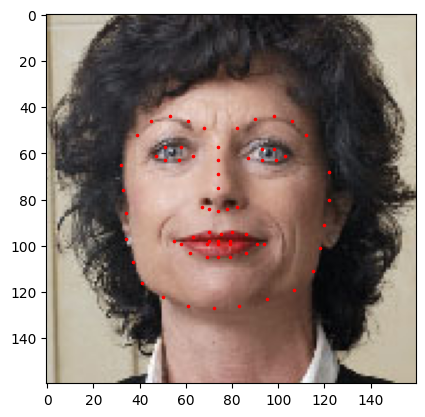

In [17]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

In [9]:
class FaceLandmarksDataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.landmarks_frame=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image=io.imread(img_name)
        landmarks=self.landmarks_frame.iloc[idx,1:]
        landmarks=np.array([landmarks])
        landmarks=landmarks.astype('float').reshape(-1,2)
        sample={'image':image,'landmarks':landmarks}
        
        if self.transform:
            sample=self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


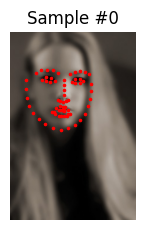

1 (500, 333, 3) (68, 2)


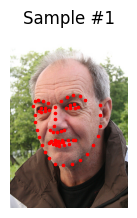

2 (250, 258, 3) (68, 2)


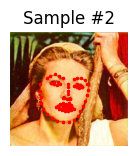

3 (434, 290, 3) (68, 2)


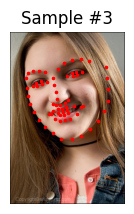

In [12]:
face_dataset=FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',root_dir='data/faces/')

fig=plt.figure()

for i in range(len(face_dataset)):
    sample=face_dataset[i]
    print(i,sample['image'].shape,sample['landmarks'].shape)
    ax=plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i==3:
        plt.show()
        break
    

In [20]:
class Rescale(object):
    def __init__(self,output_size):
        assert isinstance(output_size, (int,tuple))
        self.output_size=output_size
    
    def __call__(self,sample):
        image,landmarks=sample['image'],sample['landmarks']
        h,w=image.shape[:2]
        if isinstance(self.output_size,int):
            if h>w:
                new_h,new_w=self.output_size*h/w,self.output_size
            else:
                new_h,new_w=self.output_size,self.output_size*w/h
        else:
            new_h,new_w=self.output_size
        
        new_h,new_w=int(new_h),int(new_w)
        img=transform.resize(image,(new_h,new_w))
        
        landmarks=landmarks*[new_w/w,new_h/h]
        
        return {'image':img,'landmarks':landmarks}


In [22]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}


In [14]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

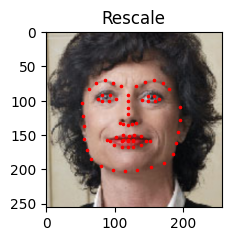

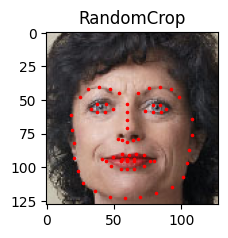

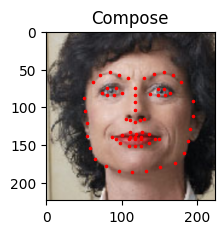

In [23]:

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    
scale=Rescale(256)
crop=RandomCrop(128)
composed=transforms.Compose([Rescale(256),RandomCrop(224)])

fig=plt.figure()
sample=face_dataset[65]
for i,tsfrm in enumerate([scale,crop,composed]):
    transformed_sample=tsfrm(sample)
    
    ax=plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
plt.show()

In [24]:
transformed_dataset=FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',root_dir='data/faces/',transform=transforms.Compose([Rescale(256),RandomCrop(224),ToTensor()]))

for i in range(len(transformed_dataset)):
    sample=transformed_dataset[i]
    print(i,sample['image'].size(),sample['landmarks'].size())
    
    if i==3:
        break
    

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


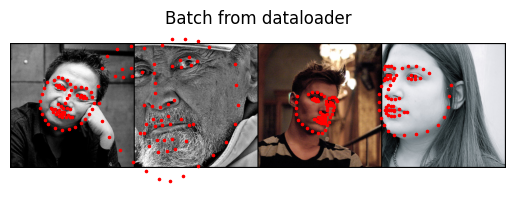

In [27]:
dataloader=DataLoader(transformed_dataset,batch_size=4,shuffle=True,num_workers=4)

def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break